# Focal Loss 

In machine learning classification tasks, if you have an imbalanced training set and apply the training set directly for training, the overall accuracy might be good, but for some minority classes, their accuracy might be bad because they are overlooked during training. 

The focal loss is designed to address class imbalance by down-weighting inliers (easy examples) such that their contribution to the total loss is small even if their number is large. It focuses on training a sparse set of hard examples.

An example can be called easy if it doesn’t explain the pattern for a particular class well(or barely helps in discriminating that class with other classes)

 loss function called focal loss which penalizes easily classified examples  i.e. background in our case

Link to the paper: https://arxiv.org/pdf/1708.02002.pdf

include entropy loss function here:

Such easy examples are well classified i.e. with a probability >> 0.5, as a result of which their contribution to the loss is very less. But what if such examples are way greater than the number of positive examples? — in a ratio 10000:1 negatives to positives. Then its contribution to the loss is huge, thereby causing the network biased to background class.

include focal loss function here:

To avoid the contribution of such easy examples to the loss, 1 — their probabilities are multiplied with their original loss values, eventually diminishing their losses.

Hence if an example is easily classified, then its probability p would be >> 0.5(close to 0.9–1.0) and 1 — p which is close to zero causes C.E to produce a very small value, ending up in very low or no learning for that example. The term γ is the focusing parameter which adjusts the rate at which easy examples are downweighted.


There are two adjustable parameters for focal loss.:
        
  1. $\gamma$ (gamma): smoothly adjusts the rate at which easy examples are down-weighted. When γ = 0, focal loss is equivalent to categorical cross-entropy, and as γ is increased the effect of the modulating factor is likewise increased (γ = 2 works best in experiments)
  
  2. $\alpha$ (alpha): balances focal loss, yields slightly improved accuracy over the non-α-balanced form. 
   
   
  
links:
1. https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
2. https://leimao.github.io/blog/Focal-Loss-Explained/

## without  focal loss

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
np.random.seed(42)

from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense

%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [49]:
# create data frame containing your data, each column can be accessed # by df['column   name']
dataset = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')
del dataset['nameDest']
del dataset['nameOrig']
del dataset['type']

dataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [30]:
dataset['isFraud'].value_counts()


0    6354407
1       8213
Name: isFraud, dtype: int64

In [31]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [32]:
#Splitting the Training/Test Data

from sklearn.model_selection  import train_test_split
X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
y = keras.utils.to_categorical(y, num_classes=2)
X = feature_normalize(X.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [33]:
model = Sequential()

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
model.add(Dense(20, activation='relu', name='fc1'))
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense(nb_classes, activation='softmax', name='output'))

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [35]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                70        
_________________________________________________________________
fc1 (Dense)                  (None, 20)                220       
_________________________________________________________________
fc2 (Dense)                  (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


In [36]:
# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = {0 : 1., 1: 20.}
model.fit(X_train, y_train, epochs=3, batch_size=1000, class_weight=class_weight)

  ...
    to  
  ['...']
Train on 5090096 samples
Epoch 1/3
5090096/5090096 [==============================] - 7s 1us/sample - loss: 0.0644 - accuracy: 0.9982
Epoch 2/3
5090096/5090096 [==============================] - 6s 1us/sample - loss: 0.0403 - accuracy: 0.9981
Epoch 3/3
5090096/5090096 [==============================] - 6s 1us/sample - loss: 0.0354 - accuracy: 0.9983


In [37]:
score = model.evaluate(X_test, y_test, batch_size=1000)
score

1272524/1272524 [==============================] - 1s 1us/sample - loss: 0.0102 - accuracy: 0.9987


[0.010173748468353191, 0.99872535]

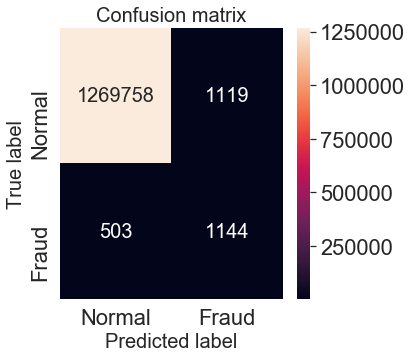

In [38]:
predictions = model.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [40]:
# total miss classified labels

values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
error_count

1622

## with focal loss

In [41]:
model_focal = Sequential()


input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

model_focal.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
model_focal.add(Dense(20, activation='relu', name='fc1'))
model_focal.add(Dense(10, activation='relu', name='fc2'))
model_focal.add(Dense(nb_classes, activation='softmax', name='output'))

In [42]:

class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=0.25,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)


model_focal.compile(loss=FocalLoss(alpha=1),
              optimizer='nadam',
              metrics=['accuracy'])

In [43]:
model_focal.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                70        
_________________________________________________________________
fc1 (Dense)                  (None, 20)                220       
_________________________________________________________________
fc2 (Dense)                  (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_focal.fit(X_train, y_train, epochs=3, batch_size=1000)


Train on 5090096 samples
Epoch 1/3
5090096/5090096 [==============================] - 7s 1us/sample - loss: 0.0034 - accuracy: 0.9978
Epoch 2/3
5090096/5090096 [==============================] - 6s 1us/sample - loss: 0.0013 - accuracy: 0.9993
Epoch 3/3
5090096/5090096 [==============================] - 6s 1us/sample - loss: 0.0011 - accuracy: 0.9993


In [45]:
score = model_focal.evaluate(X_test, y_test, batch_size=1000)
score

1272524/1272524 [==============================] - 1s 1us/sample - loss: 0.0010 - accuracy: 0.9993


[0.0010400181678136705, 0.9993289]

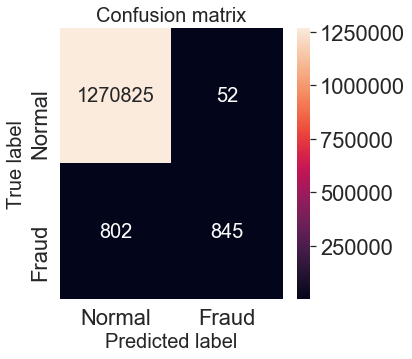

In [46]:
predictions_focal = model_focal.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions_focal, axis=1)
confusion_matrix_focal = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix_focal, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [47]:
values_focal = confusion_matrix_focal.view()
error_count = values_focal.sum() - np.trace(values_focal)
error_count

854